# 4. Multivariate Thinking
**Explore multivariate relationships using multiple regression to describe non-linear relationships and logistic regression to explain and predict binary variables.**

## Limits of simple regression
Regression is not symmetric; the regression of A onto B is not the same as the regression of B onto A.

A might cause B, or B might cause A, or there might be other factors that cause both A and B. Regression alone can't tell you which way it goes.

### Multiple regression
However, we have tools for teasing apart relationships among multiple variables; one of the most important is multiple regression.

SciPy doesn't do multiple regression, so we have to switch to a new library, StatsModels. Here's the import statement. 

In [1]:
import statsmodels.formula.api as smf

And here's how we use it.

In [2]:
import pandas as pd
brfss = pd.read_hdf('brfss.hdf5', 'brfss')

In [3]:
results = smf.ols('INCOME2 ~ _VEGESU1', data=brfss).fit()
results.params

Intercept    5.450700
_VEGESU1     0.204935
dtype: float64

`ols` stands for "ordinary least squares", another name for regression. The first argument is a formula string that specifies that we want to regress income as a function of vegetable consumption. The second argument is the BRFSS DataFrame. The names in the formula correspond to columns in the DataFrame. The result from `ols()` represents the model; we have to run  `.fit()` to get the results. 

The results object contains a lot of information, but the first thing we'll look at is params, which contains the estimated slope and intercept. And we get the same results we got from SciPy.

## Regression and causation
In the BRFSS dataset, there is a strong relationship between vegetable consumption and income. The income of people who eat 8 servings of vegetables per day is double the income of people who eat none, on average.

Which of the following conclusions can we draw from this data?

    A. Eating a good diet leads to better health and higher income.
    B. People with higher income can afford a better diet.
    C. People with high income are more likely to be vegetarians.

1. ~A only.~
2. ~B only.~
3. ~B and C.~
4. **None of them.**

**Answer: 4.** *This data is consistent with all of these conclusions, but **it does not provide conclusive evidence for any of them**.*


In [4]:
from scipy.stats import linregress
import statsmodels.formula.api as smf

# Run regression with linregress
subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])
xs = subset['INCOME2']
ys = subset['_VEGESU1']
res = linregress(xs, ys)
print(res)

# Run regression with StatsModels
results = smf.ols('_VEGESU1 ~ INCOME2', data=brfss).fit()
print(results.params)

LinregressResult(slope=0.06988048092105006, intercept=1.5287786243363113, rvalue=0.11967005884864092, pvalue=1.378503916249654e-238, stderr=0.0021109763563323305, intercept_stderr=0.013196467544093591)
Intercept    1.528779
INCOME2      0.069880
dtype: float64


*When starting working with a new library, checks like this help ensure that I am doing it right.*

---

## Multiple regression
###  Income and education
First, load the GSS data.

In [5]:
gss = pd.read_hdf('gss.hdf5', 'gss')

Then run a regression of real income as a function of years of education. 

The first argument of `ols()` is a formula that specifies the variables in the regression. On the left, realinc is the variable we are trying to predict; on the right, educ is the variable for using to inform the predictions. And here are the results.

In [6]:
results = smf.ols('realinc ~ educ', data=gss).fit()
results.params

Intercept   -11539.147837
educ          3586.523659
dtype: float64

The estimated slope is 3586, which means that each additional year of education is associated with an increase of almost $3600 of income. But income also depends on age, so it would be good to include that in the model, too.

### Adding age
Here's how. On the right side of the formula, it is possible to list as many variables as like, in this case, there are `educ` and `age`. The plus sign indicates that we expect the contributions of the two variables to be additive, which is a common assumption for models like this. Here are the results. 

In [7]:
results = smf.ols('realinc ~ educ + age', data=gss).fit()
results.params

Intercept   -16117.275684
educ          3655.166921
age             83.731804
dtype: float64

The estimated slope for education is 3655, a little more than in the previous model. The estimated slope for age is only about $80 per year, which is surprisingly small.

###  Income and age
To see what's going on, let's look more closely at the relationship between income and age. I'll use `groupby()`, which is a Pandas feature we haven't seen before, to divide the DataFrame into age groups. 

In [8]:
grouped = gss.groupby('age')
grouped

The result is a GroupBy object that contains one group for each value of age. The GroupBy object behaves like a DataFrame in many ways. It is possible to use brackets to select a column, like realinc in this example, and then invoke a method like `mean()`. 

In [9]:
mean_income_by_age = grouped['realinc'].mean()

The result is a Pandas series that contains the mean income for each age group, which we can plot like this.

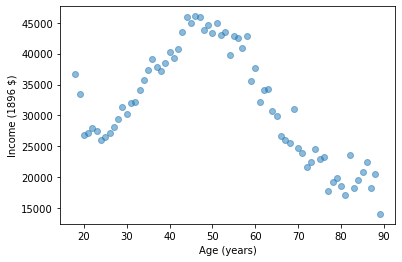

In [10]:
import matplotlib.pyplot as plt
plt.plot(mean_income_by_age, 'o', alpha=0.5)
plt.xlabel('Age (years)')
plt.ylabel('Income (1896 $)')
plt.show()

### Mean income over age
Here's the result. Average income increases from age 20 to age 50, then starts to fall. And that explains why the estimated slope is so small, because the relationship is non-linear.

Remember that correlation and simple regression can't measure non-linear relationships. **But multiple regression can.**

### Adding a quadratic term
To describe a non-linear relationship, one option is to add a new variable that is a non-linear combination of other variables. 

As an example, let's create a new variable called `age2` that equals age squared. Now we can run a regression with both `age` and `age2` on the right side. And here are the results. 

In [11]:
gss['age2'] = gss['age']**2

model = smf.ols('realinc ~ educ + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -48058.679679
educ          3442.447178
age           1748.232631
age2           -17.437552
dtype: float64

The slope associated with age is substantial, about $1700 per year. The slope associated with `age2` is about -17, which is harder to interpret.

## Plot income and education
To get a closer look at the relationship between income and education, let's use the variable `'educ'` to group the data, then plot mean income in each group.

- Group `gss` by `'educ'`. Store the result in grouped.
- From `grouped`, extract `'realinc'` and compute the mean.
- Plot `mean_income_by_educ` as a scatter plot. Specify `'o'` and `alpha=0.5`.

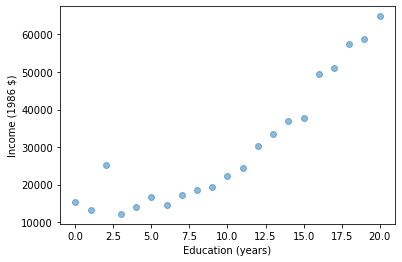

In [12]:
# Group by educ
grouped = gss.groupby('educ')

# Compute mean income in each group
mean_income_by_educ = grouped['realinc'].mean()

# Plot mean income as a scatter plot
plt.plot(mean_income_by_educ, 'o', alpha=0.5)

# Label the axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.show()

*It looks like the relationship between income and education is non-linear.*

## Non-linear model of education
The graph above exercise suggests that the relationship between income and education is non-linear. So let's try fitting a non-linear model.

- Add a column named `'educ2'` to the `gss` DataFrame; it should contain the values from `'educ'` squared.
- Run a regression model that uses `'educ'`, `'educ2'`, `'age'`, and `'age2'` to predict `'realinc'`.

In [13]:
import statsmodels.formula.api as smf

# Add a new column with educ squared
gss['educ2'] = gss['educ']**2

# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss).fit()

# Print the estimated parameters
print(results.params)

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64


*The slope associated with `educ2` is positive, so the model curves upward.*

---

## Visualizing regression results
Here, let's see a way to interpret them visually, and to validate them against data.

### Modeling income and age
Here's the model from the previous exercise. First, create new variables for educ squared and age squared. Then run the regression model with `educ`, `educ2`, `age`, and `age2`. And here are the results. 

In [15]:
gss['age2'] = gss['age']**2
gss['educ2'] = gss['educ']**2

model = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss)
results = model.fit()
results.params

Intercept   -23241.884034
educ          -528.309369
educ2          159.966740
age           1696.717149
age2           -17.196984
dtype: float64

The parameters are hard to interpret. Fortunately, don't have to -- sometimes the best way to understand a model is by looking at its predictions rather than its parameters.

### Generating predictions
The regression results object provides a method called `predict()` that uses the model to generate predictions. It takes a DataFrame as a parameter and returns a Series with a prediction for each row in the DataFrame. 

To use it, create a new DataFrame with age running from 18 to 85, and `age2` set to age squared. 

In [19]:
import numpy as np
df = pd.DataFrame()
df['age'] = np.linspace(18, 85)
df['age2'] = df['age']**2

Next, pick a level for `educ`, like 12 years, which is the most common value. 

In [20]:
df['educ'] = 12
df['educ2'] = df['educ']**2

When assigning a single value to a column in a DataFrame, Pandas makes a copy for each respondent. Then it's possible to use results to predict the average income for each age group, holding education constant.

In [21]:
pred12 = results.predict(df)

### Plotting predictions
The result from `predict()` is a Series with one prediction for each row. So it's possible to can plot it like this, with age on the x-axis and the predicted income for each age group on the y-axis. 

It's possible to can plot the data for comparison, and should label the axes, as always.

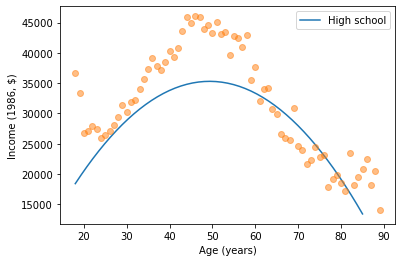

In [25]:
plt.plot(df['age'], pred12, label='High school')

plt.plot(mean_income_by_age, 'o', alpha=0.5)

plt.xlabel('Age (years)')
plt.ylabel('Income (1986, $)')
plt.legend()
plt.show()

### Comparing with data
Here are the results. The orange dots show the average income in each age group. The blue line shows the predictions generated by the model, holding education constant. This plot shows the shape of the model, a downward-facing parabola.

### Levels of education
It's possible to do the same thing with other levels of education, like 14 years, which is the nominal time to earn an Associate's degree, 

In [30]:
df['educ'] = 14
df['educ2'] = df['educ']**2
pred14 = results.predict(df)

and 16 years, which is the nominal time to earn a Bachelor's degree.

In [31]:
df['educ'] = 16
df['educ2'] = df['educ']**2
pred16 = results.predict(df)

### Interpreting the results
And here are the results.

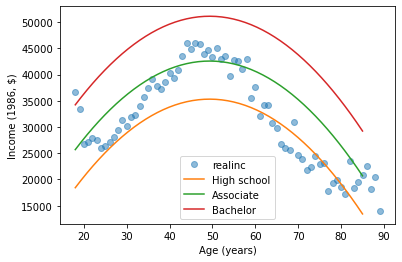

In [34]:
plt.plot(mean_income_by_age, 'o', alpha=0.5, label='realinc')
plt.plot(df['age'], pred12, label='High school')
plt.plot(df['age'], pred14, label='Associate')
plt.plot(df['age'], pred16, label='Bachelor')

plt.xlabel('Age (years)')
plt.ylabel('Income (1986, $)')
plt.legend()
plt.show()

The lines show mean income, as predicted by the model, as a function of age, for three levels of education. This visualization helps validate the model since we can compare the predictions with the data. And it helps us interpret the model since we can see the separate contributions of age and education.

## Making predictions
At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding `age` constant.

- Using `np.linspace()`, add a variable named `'educ'` to `df` with a range of values from `0` to `20`.
- Add a variable named `'age'` with the constant value `30`.
- Use `df` to generate predicted income as a function of education.

In [35]:
# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss).fit()

# Make the DataFrame
df = pd.DataFrame()
df['educ'] = np.linspace(0, 20)
df['age'] = 30
df['educ2'] = df['educ']**2
df['age2'] = df['age']**2

# Generate and plot the predictions
pred = results.predict(df)
print(pred.head())

0    12182.344976
1    11993.358518
2    11857.672098
3    11775.285717
4    11746.199374
dtype: float64


*Next, let's see what the results look like.*

## Visualizing predictions
Now let's visualize the results from the previous exercise!

- Plot `mean_income_by_educ` using circles (`'o'`). Specify an `alpha` of `0.5`.
- Plot the prediction results with a line, with `df['educ']` on the x-axis and `pred` on the y-axis.

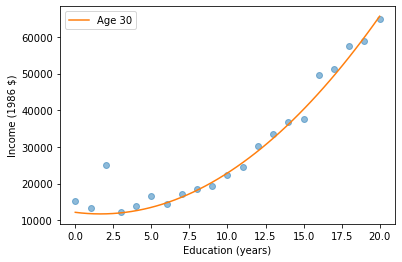

In [36]:
# Plot mean income in each age group
plt.clf()
grouped = gss.groupby('educ')
mean_income_by_educ = grouped['realinc'].mean()
plt.plot(mean_income_by_educ, 'o', alpha=0.5)

# Plot the predictions
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Age 30')

# Label axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.legend()
plt.show()

*Looks like this model captures the relationship pretty well.*

---

## Logistic regression
### Categorical variables
To understand logistic regression, have to start with categorical variables. Most of the variables have been used so far - like income, age, and education - are **numerical**. 

But variables like sex and race are **categorical**; that is, each respondent belongs to one of a specified set of categories.

With StatsModels, it is easy to include a categorical variable as part of a regression model. Here's how. 

In the formula string, the letter `C` indicates that `sex` is a **categorical variable**. And here are the results. 


In [37]:
formula = 'realinc ~ educ + educ2 + age + age2 + C(sex)'
results = smf.ols(formula, data=gss).fit()
results.params

Intercept     -22369.453641
C(sex)[T.2]    -4156.113865
educ            -310.247419
educ2            150.514091
age             1703.047502
age2             -17.238711
dtype: float64

The regression treats the value `sex=1`, which is male, as the default, and reports the difference associated with the value `sex=2`, which is female. So this result indicates that income for women is about $4100 less than for men, after controlling for age and education.

### Boolean variable
If a categorical variable has only two values, it's called a boolean variable. 

For example, one of the questions in the General Social Survey asks *"Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?"*

The variable is called `gunlaw`, and here are the values. 

In [38]:
gss['gunlaw'].value_counts()

1.0    30918
2.0     9632
Name: gunlaw, dtype: int64

`1` means *yes* and `2` means *no*, so most respondents are in favor. 

To explore the relationship between this variable and factors like age, sex, and education, it's possible to use logistic regression. StatsModels provides logistic regression, but to use it, have to recode the variable so 1 means yes and 0 means no. it's possible to do that by replacing 2 with 0. And we can check the results.

In [40]:
gss['gunlaw'].replace([2], [0], inplace=True)

gss['gunlaw'].value_counts()

1.0    30918
0.0     9632
Name: gunlaw, dtype: int64

### Logistic regression
Now it's possible to run the regression. 

Instead of `ols()`, use `logit()`, which is named for the logit function, which is related to logistic regression. Other than that, everything is the same as what have seen before. And here are the results.

In [42]:
formula = 'gunlaw ~ age + age2 + educ + educ2 + C(sex)'
results = smf.logit(formula, data=gss).fit()

results.params

Optimization terminated successfully.
         Current function value: 0.533674
         Iterations 6


Intercept      1.653862
C(sex)[T.2]    0.757249
age           -0.018849
age2           0.000189
educ          -0.124373
educ2          0.006653
dtype: float64

The parameters are in the form of "log odds", which is not familiar with. Won't explain them in detail here, except to say that positive values are associated with things that make the outcome more likely; negative values make the outcome less likely. For example, the parameter associated with `sex=2` is `0.75`, which indicates that women are more likely to support this form of gun control. To see how much more likely, generate and plot predictions, as done with linear regression.

### Generating predictions
As an example, predictions for different ages and sexes will be generated, with education held constant. First need a DataFrame with `age` and `educ`. 

In [46]:
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['educ'] = 12

Then can compute `age2` and `educ2`.

In [47]:
df['age2'] = df['age']**2
df['educ2'] = df['educ']**2

Here, it's possible to generate predictions for men like this. 

In [52]:
df['sex'] = 1
pred1 = results.predict(df)

And for women like this.

In [53]:
df['sex'] = 2
pred2 = results.predict(df)

### Visualizing results
Now, to visualize the results, start by plotting the data. As done before, the respondents into age groups and compute the mean in each group will be divided. The mean of a binary variable is the fraction of people in favor. Now the predictions can be predicted, for men and women, as a function of age. And label the axes.

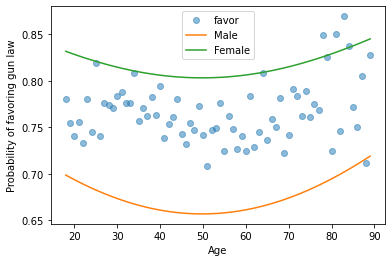

In [55]:
grouped = gss.groupby('age')
favor_by_age = grouped['gunlaw'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5, label='favor')

plt.plot(df['age'], pred1, label='Male')
plt.plot(df['age'], pred2, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring gun law')
plt.legend()
plt.show()

### Gun laws and age
Here's what it looks like. According to the model, people near age 50 are least likely to support gun control (at least as this question was posed). And women are more likely to support it than men, by almost 15 percentage points.

Indeed, logistic regression is a powerful tool for exploring relationships between a binary variable and the factors that predict it. 

## Predicting a binary variable
Let's use logistic regression to predict a binary variable. Specifically, we'll use age, sex, and education level to predict support for legalizing cannabis (marijuana) in the U.S.

In the GSS dataset, the variable `grass` records the answer to the question *"Do you think the use of marijuana should be made legal or not?"*

- Fill in the parameters of `smf.logit()` to predict `grass` using the variables `age`, `age2`, `educ`, and `educ2`, along with `sex` as a categorical variable.

In [56]:
# Recode grass
gss['grass'].replace(2, 0, inplace=True)

# Run logistic regression
results = smf.logit('grass ~ age + age2 + educ + educ2 + C(sex)', data=gss).fit()
results.params

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


Intercept     -1.685223
C(sex)[T.2]   -0.384611
age           -0.034756
age2           0.000192
educ           0.221860
educ2         -0.004163
dtype: float64

- Add a column called `educ` and set it to 12 years; then compute a second column, `educ2`, which is the square of `educ`.

In [57]:
# Make a DataFrame with a range of ages
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

# Set the education level to 12
df['educ'] = 12
df['educ2'] = df['educ']**2

- Generate separate predictions for men and women.

In [58]:
# Generate predictions for men and women
df['sex'] = 1
pred1 = results.predict(df)

df['sex'] = 2
pred2 = results.predict(df)

- Fill in the missing code to compute the mean of `'grass'` for each age group, and then the arguments of `plt.plot()` to plot `pred2` versus `df['age']` with the label `'Female'`.

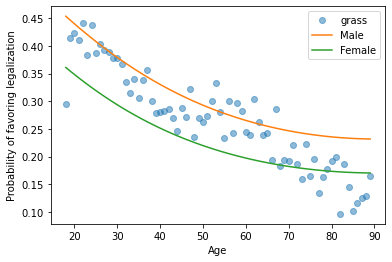

In [60]:
plt.clf()
grouped = gss.groupby('age')
favor_by_age = grouped['grass'].mean()
plt.plot(favor_by_age, 'o', alpha=0.5, label='grass')

plt.plot(df['age'], pred1, label='Male')
plt.plot(df['age'], pred2, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring legalization')
plt.legend()
plt.show()

---

## Summary
### Exploratory Data Analusis
- Import, clean, and validate
- Visualize distributions
- Explore relationships between variables
- Explore multivariate relationships

### CDF, PMF, and KDE
- Use CDFs for exploration
- Use PMFs if there are a small number of unique values
- Use KDE if there are a lot of values